In [1]:
import yfinance as yf
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandasgui import show
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dfInfoEmpresas = pd.read_csv('informationCompanies.csv')

In [3]:
dfInfoEmpresas = dfInfoEmpresas[dfInfoEmpresas['fullTimeEmployees'].notna()]
dfInfoEmpresas =dfInfoEmpresas.drop(['lastSplitFactor', 'lastSplitDate',
                     'fiveYearAvgDividendYield','dividendRate',
                     'dividendYield','industrySymbol',
                     'address2','trailingPegRatio',
                     'lastDividendDate', 'maxAge', 'previousClose', 'open', 
                    'dayLow', 'dayHigh', 'regularMarketPreviousClose',
                    'regularMarketOpen',  'regularMarketDayLow',
                    'regularMarketDayHigh', 'trailingPE', 
                    'governanceEpochDate', 'compensationAsOfEpochDate',
                    'gmtOffSetMilliseconds'], axis=1)

In [4]:
nombres = dfInfoEmpresas[['symbol','shortName']]

In [5]:
nombres

,symbol,shortName
0,MMM,3M Company
1,AOS,A.O. Smith Corporation
2,ABT,Abbott Laboratories
3,ABBV,AbbVie Inc.
4,ACN,Accenture plc
...,...,...
498,YUM,"Yum! Brands, Inc."
499,ZBRA,Zebra Technologies Corporation
500,ZBH,"Zimmer Biomet Holdings, Inc."
501,ZION,Zions Bancorporation N.A.


In [6]:
dfInfoEmpresas = dfInfoEmpresas.drop(['symbol','shortName'], axis=1)

In [7]:
dfInfoEmpresas

,Unnamed: 0,fullTimeEmployees,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,priceHint,exDividendDate,payoutRatio,...,returnOnAssets,returnOnEquity,grossProfits,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins
0,0,92000.0,8.0,7.0,5.0,4.0,6.0,2.0,1.684368e+09,0.6167,...,0.06742,0.36034,1.500000e+10,3.498250e+09,5.855000e+09,-0.221,-0.090,0.42547,0.20460,0.14962
1,1,12000.0,2.0,10.0,7.0,10.0,10.0,2.0,1.682554e+09,0.7296,...,0.12177,0.13492,1.329600e+09,3.090125e+08,4.948000e+08,0.105,-0.012,0.36394,0.19649,0.17624
2,2,115000.0,8.0,9.0,9.0,2.0,8.0,2.0,1.681344e+09,0.5836,...,0.06318,0.15932,2.457900e+10,6.409875e+09,8.659000e+09,-0.453,-0.181,0.55639,0.25831,0.18000
3,3,50000.0,9.0,7.0,7.0,9.0,9.0,2.0,1.681344e+09,1.3435,...,0.09443,0.51275,4.152700e+10,2.160288e+10,2.422800e+10,-0.949,-0.097,0.70959,0.52031,0.36979
4,4,738000.0,1.0,3.0,4.0,4.0,1.0,2.0,1.681258e+09,0.3849,...,0.13110,0.30949,1.970154e+10,8.329611e+09,9.680274e+09,-0.059,0.051,0.32120,0.16945,0.15288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,498,36000.0,1.0,2.0,10.0,7.0,8.0,2.0,1.685059e+09,0.5434,...,0.23843,NaN,3.307000e+09,7.075000e+08,1.523000e+09,-0.228,0.063,0.48501,0.33775,0.31787
499,499,10500.0,1.0,9.0,8.0,9.0,8.0,2.0,NaN,0.0000,...,0.08776,0.14076,2.624000e+09,7.526250e+08,3.580000e+08,-0.243,-0.019,0.46124,0.20003,0.16597
500,500,18000.0,2.0,8.0,10.0,4.0,8.0,2.0,1.687478e+09,0.4486,...,0.04118,0.03728,4.920400e+09,1.391900e+09,1.355200e+09,15.353,0.101,0.71576,0.32870,0.19864
501,501,10064.0,3.0,5.0,5.0,5.0,4.0,2.0,1.684282e+09,0.2752,...,0.01010,0.15822,3.030000e+09,NaN,1.403000e+09,0.047,0.104,0.00000,0.00000,0.39581


In [8]:
show(dfInfoEmpresas)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [9]:
print((((dfInfoEmpresas).isna()).sum()).to_string())

Unnamed: 0                       0
fullTimeEmployees                0
auditRisk                        2
boardRisk                        2
compensationRisk                 2
shareHolderRightsRisk            2
overallRisk                      2
priceHint                        0
exDividendDate                  71
payoutRatio                     24
beta                             7
forwardPE                        1
volume                           0
regularMarketVolume              0
averageVolume                    0
averageVolume10days              0
averageDailyVolume10Day          0
bid                              0
ask                              0
bidSize                          0
askSize                          0
marketCap                        0
fiftyTwoWeekLow                  0
fiftyTwoWeekHigh                 0
priceToSalesTrailing12Months     1
fiftyDayAverage                  0
twoHundredDayAverage             0
trailingAnnualDividendRate       0
trailingAnnualDivide

In [10]:
imputer = KNNImputer(n_neighbors=100)

In [11]:
dfImputado = imputer.fit_transform(dfInfoEmpresas)

In [12]:
nombreColumnas = list(dfInfoEmpresas.columns)

In [13]:
dfImputado = pd.DataFrame(dfImputado, columns = nombreColumnas)

In [14]:
marketCap = dfImputado[['marketCap']]
logMarketCap = np.log2(marketCap)
dfImputadoX = dfImputado.drop(['marketCap'], axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dfImputadoX, logMarketCap, test_size=0.2, random_state=42)

In [28]:
with pm.Model() as model:
    betas = pm.Normal('betas', mu=1, sigma=500, shape=83)

    # model error
    sigma = pm.Exponential("sigma", lam=1/100)
    intercept = pm.Exponential('intercept', lam=1/100)
    # matrix-dot products
    m1 = pm.math.matrix_dot(X_train, betas)

    # Likelihood: Normal
    y = pm.Normal("y",
                  mu=m1+intercept,
                  sigma=sigma,
                  observed=y_train
                  )

    trace = pm.sample(1000, tune=100)

C:\Users\fridm\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, betas]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 50 seconds.
There were 514 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 509 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 488 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 492 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat sta

C:\Users\fridm\AppData\Local\Temp\ipykernel_7692\488324252.py:2: DeprecationWarning:

The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning:

Your data appears to have a single value or no finite values

C:\Users\fridm\anaconda3\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning:

Your data appears to have a single value or 

<Figure size 700x700 with 0 Axes>

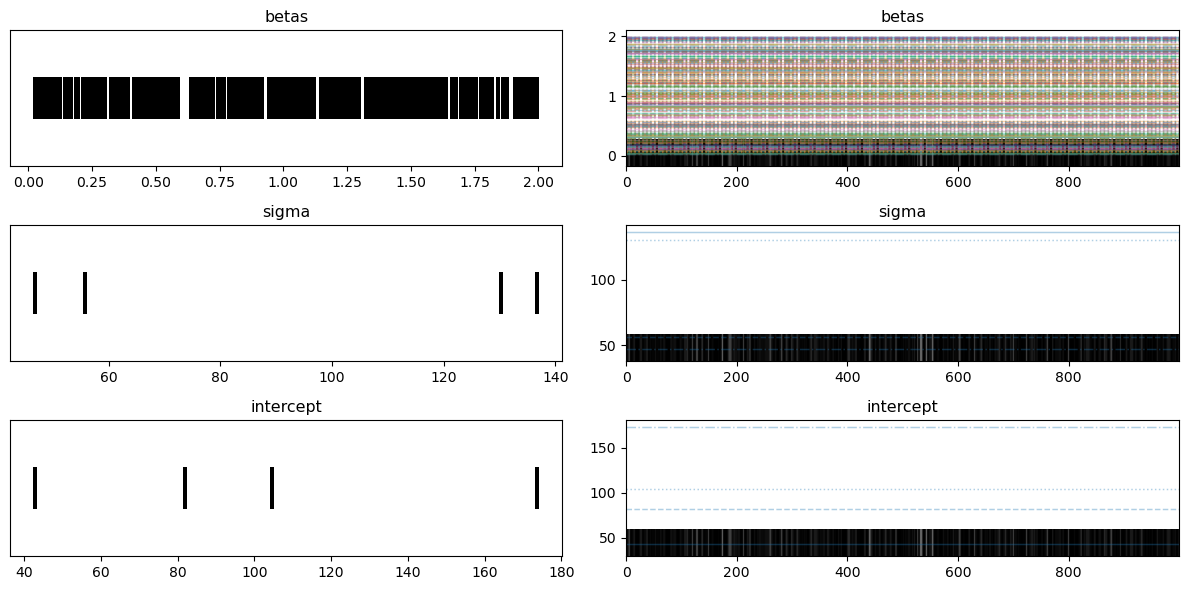

In [29]:
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()